Based on a project done at NYU (May 2017)

Revised in 2018


Zhanna Zhanabekova

IPython Notebook #1 of 3: Load and explore data. Transform variables.

Versions of key packages used (Anaconda 4.5.12):

- Python 3.7.1
- numpy 1.15.4
- pandas 0.23.4
- statsmodels 0.9.0


**The goal of this project** is to predict the outcome of credit card-related consumer complaints filed with the Consumer Financial Protection Bureau (CFPB). Here, an outcome could result in monetary relief or be settled otherwise.



The data was originally downloaded from the CFPB website on March 20, 2017. See Consumer Complaint Database at: https://www.consumerfinance.gov/data-research/consumer-complaints.
        

In [65]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# Import useful packages
import os
import pandas as pd
import numpy as np
import csv
import pickle
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import functions as f

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Set up directory path and load the CFPB data
directory = os.getcwd() + '/Data/'
df =pd.read_csv(directory+ 'Consumer_Complaints_loaded_March20_2017.csv', \
                header = 0, sep = ',', dtype = 'str')
# NOTE: This file was too big to save on Github so I posted a smaller version of it with 
# credit card complaints only - please see below

# List column names
print(df.columns)
print()

# Print the number of observations
print('N = ', df.shape[0])
print()

# Examine the first 5 rows of data (transposed)
df.head().T

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

N =  738832



,0,1,2,3,4
Date received,07/29/2013,07/29/2013,07/29/2013,07/29/2013,07/29/2013
Product,Consumer Loan,Bank account or service,Bank account or service,Bank account or service,Mortgage
Sub-product,Vehicle loan,Checking account,Checking account,Checking account,Conventional fixed mortgage
Issue,Managing the loan or lease,Using a debit or ATM card,"Account opening, closing, or management",Deposits and withdrawals,"Loan servicing, payments, escrow account"
Sub-issue,NaN,NaN,NaN,NaN,NaN
Consumer complaint narrative,NaN,NaN,NaN,NaN,NaN
Company public response,NaN,NaN,NaN,NaN,NaN
Company,Wells Fargo & Company,Wells Fargo & Company,Santander Bank US,Wells Fargo & Company,Franklin Credit Management
State,VA,CA,NY,GA,CT
ZIP code,24540,95992,10065,30084,06106


## Outcome variable: *Company response to consumer*

In [3]:
# Tabulate outcome variable 'Company response to consumer'
df['Company response to consumer'].value_counts()


Closed with explanation            549671
Closed with non-monetary relief     91580
Closed with monetary relief         49392
Closed without relief               17863
Closed                              17004
Closed with relief                   5298
Untimely response                    4037
In progress                          3987
Name: Company response to consumer, dtype: int64

In [4]:
# Drop "In progress" observations
df = df[df['Company response to consumer'] != 'In progress']

# Generate a binary outcome variable - closed with monetary relief (1) or otherwise (0)
df['Y'] = np.where(df['Company response to consumer'] == 'Closed with monetary relief', 1,0)

#Select only credit card-related complaints
df = df[df.Product == 'Credit card']
print('N = ', df.shape[0])

N =  85835


In [5]:
# Tabulate the binary outcome variable (#):
print(df.Y.value_counts())
print()

# Tabulate the binary outcome variable (%):
print(df.Y.value_counts()/df.shape[0])
print()

# Drop 'Company response to consumer' variable
del df['Company response to consumer']

0    68036
1    17799
Name: Y, dtype: int64

0    0.792637
1    0.207363
Name: Y, dtype: float64



In [6]:
# Export the smaller version of the CFPB dataset with credit card complaints only to csv and post it on Github
#df.to_csv(directory+'Consumer_Complaints_loaded_March20_2017_CREDIT_CARDS.csv')


## Data clean-up and feature engineering

In [7]:
# Identify variables with missing values 
## Note that 'Sub-product' and 'Sub-issue' have all values missing (drop these below)
print('VARIABLES WITH MISSING VALUES: ')
print()
for i in df.columns:
    count_nulls = df[i].isna().sum() 
    if count_nulls >0 and count_nulls == df.shape[0]:
        print('{}, {}, ALL NULLS'.format(i, df[i].isna().sum()))
    elif count_nulls>0:
        print('{},'.format(i), df[i].isna().sum())
        

VARIABLES WITH MISSING VALUES: 

Sub-product, 85835, ALL NULLS
Sub-issue, 85835, ALL NULLS
Consumer complaint narrative, 69040
Company public response, 66721
State, 715
ZIP code, 716
Tags, 72860
Consumer consent provided?, 57400
Consumer disputed?, 3307


In [8]:
# Check that the Complaint ID is unique. Drop it (below).
print(df['Complaint ID'].nunique() == df.shape[0])


True


### Variable *Issue*

In [9]:
# Tabulate 'Issue'
df.Issue.value_counts(dropna=False)/df.shape[0]


Billing disputes                            0.168474
Other                                       0.103268
Identity theft / Fraud / Embezzlement       0.094472
Closing/Cancelling account                  0.071474
APR or interest rate                        0.062841
Late fee                                    0.040939
Customer service / Customer relations       0.039343
Delinquent account                          0.035848
Credit determination                        0.034427
Advertising and marketing                   0.033110
Rewards                                     0.032574
Credit card protection / Debt protection    0.030757
Transaction issue                           0.030291
Billing statement                           0.029615
Payoff process                              0.026108
Credit line increase/decrease               0.024652
Other fee                                   0.024570
Unsolicited issuance of credit card         0.020504
Credit reporting                            0.

In [10]:
# Number of Issue categories
df.Issue.nunique()


33

**Variable *Issue* has 33 categories**, including "Other." The number of observations in some categories is relatively small (a few hundred observations). Hence, such label/category **granularity may introduce too much noise.** 

In addition, since I will have to create indicator/dummy variables for 32 categories, one needs to keep in mind that unbalanced dummy variables may also lead to **convergence issues when estimating the logistic regression. That is, an indicator variable with too many zeros may render the variance-covariance matrix to be non-invertibe (singular).** 

Hence, I group Issue categories that encompass less than 2% of credit card complaints (~1,700) into "Issues-Other groupped" category and end up with **19 recoded Issue categrories** (including "Other" and "Other groupped").


In [11]:
# Identify Issue categories that capture less than 2% of all credit card complaints 
#(where 2% is arbitrary) and group the identified categories into "Issue-Other groupped"
df = f.group_categories_with_less_than_X_percent_into_Other(df, 'Issue', 0.02)

# Number of unique categories in the recoded Issue variable  
df.Issue_recoded.nunique()

19

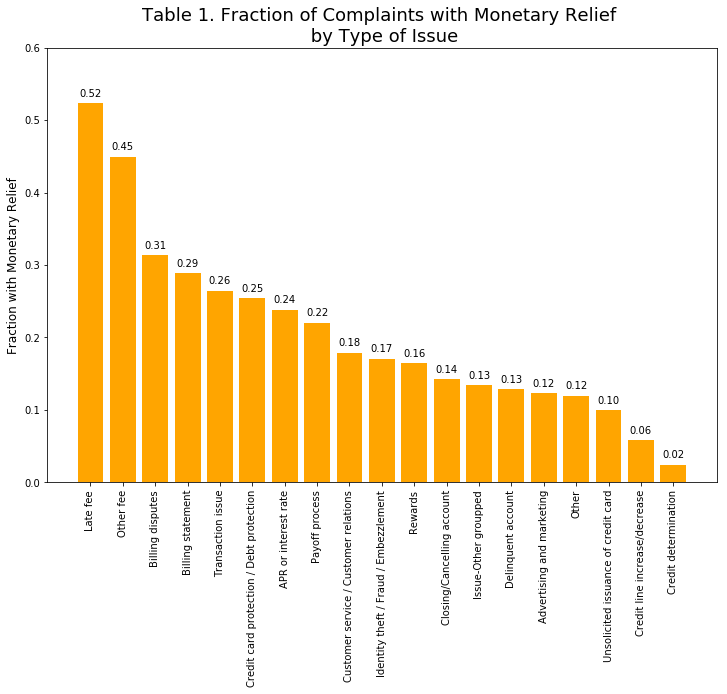

In [12]:
# Plot fraction of outcomes with monetary relief by categories in recoded Issue 
# Calculate mean(Y) by category = fraction of complaints with monetary relief in a category
Y_by_Issue_recoded = f.fraction_of_outcomes_with_monetary_relief(df,'Issue_recoded')

#bar chart
f.bar_chart_Y_by_categories_of_variable(Y_by_Issue_recoded, 'Issue_recoded',
            'Table 1. Fraction of Complaints with Monetary Relief \n by Type of Issue')

It appears that **monetary compensation is more likely** to be granted for complaints related to **late fees, other fees, billing statements, and billing disputes (~in 30-50% of the cases)** than for credit determination or credit line increase/decrease complaints (~2-6%). 

Overall, 'Issue' appears to be an important factor in predicting monetary resolution. I set 'Other' to be the excluded (baseline) category in regressions.


In [13]:
# Create indicator / dummy variables for recoded 'Issue' categories 
# Let 'Other' be the excluded category in regressions (i.e., drop it)
df = f.create_dummies(df, 'Issue_recoded', 'Issue', 'Issue_Other')

### Variable *Consumer complaint narrative*

In [14]:
# Calculate % of observations when the 'Consumer complaint narrative' is present (i.e., non-Null observations)
print('% of complaints with a narrative: ', 
      format(100*df['Consumer complaint narrative'].notnull().sum()/df.shape[0], '.1f'), '%')


# Create an indicator variable for the presense of a complaint narrative 
df['Is_narrative'] = np.where(df['Consumer complaint narrative'].notnull(), 1, 0)


% of complaints with a narrative:  19.6 %


In [15]:
# Tabulate fraction of complaints with monetary relief by category 
#'Consumer complaint narrative'
Y_by_Is_Narrative = f.fraction_of_outcomes_with_monetary_relief(df,'Is_narrative')
Y_by_Is_Narrative

,Is_narrative,mean(Y)
0,1,0.232867
1,0,0.201159


Complaints *with a narrative* are slightly more likely to have monetary relief. But the difference in likelihood does not appear to be as significant as it was for some Issue categories. Hence, this variable is unlikely to contribute much to predicting the outcome of a credit card complaint.

### Variable *Company*

In [17]:
# Variable 'Company' has 400+ categories
# Print the number of distinct companies in the dataset
print('# of companies: ', df.Company.nunique())
print()

#Examine % of complaints for the top 20 companies
Company_labels= df.Company.value_counts()/df.shape[0]
Company_labels[:20]

# of companies:  418



Citibank                             0.189480
Capital One                          0.145384
JPMorgan Chase & Co.                 0.116666
Bank of America                      0.102767
Synchrony Financial                  0.098561
Amex                                 0.075261
Discover                             0.047696
Wells Fargo & Company                0.045203
Barclays PLC                         0.038679
U.S. Bancorp                         0.027565
TD Bank US Holding Company           0.014551
USAA Savings                         0.010019
PayPal Holdings, Inc.                0.007736
HSBC North America Holdings Inc.     0.007643
First National Bank of Omaha         0.006571
PNC Bank N.A.                        0.005476
Fifth Third Financial Corporation    0.004497
Navy FCU                             0.003961
Alliance Data Card Services          0.002691
SunTrust Banks, Inc.                 0.002563
Name: Company, dtype: float64

In [18]:
# Identify Companies that capture less than 2% of all credit card complaints 
#(where 2% is arbitrary) and group the identified categories into "Other groupped"
df = f.group_categories_with_less_than_X_percent_into_Other(df, 'Company', 0.02)

# Number of unique categories in the recoded Issue variable  
df.Company_recoded.nunique()

11

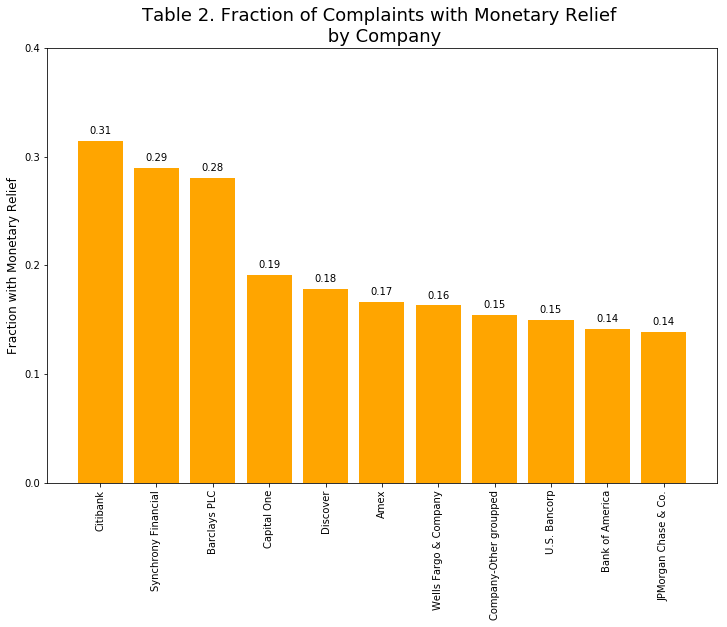

In [19]:
# Plot fraction of outcomes with monetary relief by categories in recoded Company variable
Y_by_Company_recoded = f.fraction_of_outcomes_with_monetary_relief(df,'Company_recoded')

#bar chart
f.bar_chart_Y_by_categories_of_variable(Y_by_Company_recoded, 'Company_recoded',
            'Table 2. Fraction of Complaints with Monetary Relief \n by Company')

Some companies seem more likely to offer monetary relief (e.g., *Citibank* in 31% of the cases vs *Bank of America* in only 14% of the cases). Specifically, **Citibank, Synchrony Financial, and Barclays PLC are at the top of the list of companies with high percent of resolutions with monetary relief.**

Below I check whether this may be related to the nature of the filed complains (using variable 'Issue') but there does not appear to be a signficant difference in the distribution of Issues between the two sampled companies, for example. Regardless, I will control for fixed differences across companies when modeling the outcome using company dummy variables created above.

In [20]:
# Example: Tabulate this distribution of Issues for 2 companies (for comparison)
pd.crosstab(index = df.Issue,
            columns = df[df.Company.isin(['Citibank', 'Bank of America'])].Company, 
            normalize = 'columns')


Company,Bank of America,Citibank
Issue,,
APR or interest rate,0.053622,0.061485
Advertising and marketing,0.020519,0.029575
Application processing delay,0.003741,0.004857
Arbitration,0.004308,0.003320
Balance transfer,0.015191,0.009530
Balance transfer fee,0.003514,0.001599
Bankruptcy,0.004761,0.003136
Billing disputes,0.167555,0.189621
Billing statement,0.027435,0.042179


In [21]:
# Create indicator / dummy variables for recoded 'Company' categories 
# Let 'Company-Other groupped' be the excluded category in regressions (i.e., drop it)
df = f.create_dummies(df, 'Company_recoded', 'Company', 'Company_Company-Other groupped')

### Variable *State*

In [24]:
# Tabulate variable 'State' (the first 20)
(df.State.value_counts(dropna=False)/df.shape[0])[:20]


CA    0.138160
NY    0.093284
FL    0.084779
TX    0.064216
NJ    0.043129
PA    0.038656
IL    0.036757
OH    0.034159
VA    0.033483
GA    0.033250
MD    0.029394
NC    0.027658
MA    0.025677
AZ    0.022963
MI    0.021786
WA    0.019724
CO    0.019095
CT    0.014726
WI    0.014353
TN    0.013689
Name: State, dtype: float64

Since some states and territories include a very small percentage of complaints, I group these under-represented states / territories (with less than 2% of all observations) into a larger category "Other groupped" to minimize the amount of noise that they may generate. I also include Nulls into this category. As a result, I end up with 16 categories in the recoded State variable.

In [25]:
# Identify categories of variable "State" that capture less than 2% of all credit card complaints 
#(where 2% is arbitrary) and group the identified categories into "State-Other groupped"
df = f.group_categories_with_less_than_X_percent_into_Other(df, 'State', 0.02)

# Include nulls into "State-Other groupped"
df.loc[df.State.isna(), 'State_recoded'] = "State-Other groupped"

# Number of unique categories in the recoded Issue variable  
df.State_recoded.nunique()

16

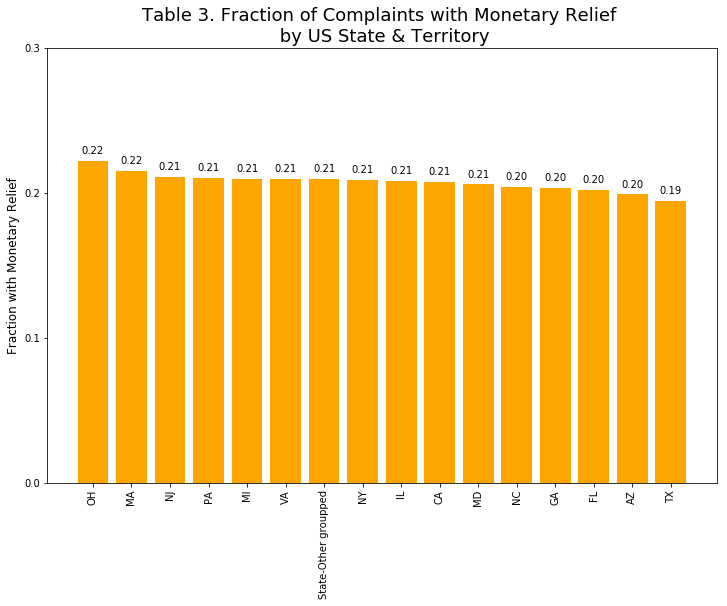

In [26]:
# Plot fraction of outcomes with monetary relief by categories in recoded State variable
Y_by_State_recoded = f.fraction_of_outcomes_with_monetary_relief(df,'State_recoded')

#bar chart
f.bar_chart_Y_by_categories_of_variable(Y_by_State_recoded, 'State_recoded',
            'Table 3. Fraction of Complaints with Monetary Relief \n by US State & Territory')

There seems to be little variation in the likelihood of monetary compensation by state as % of positive outcome ranges from 19% to 22%. This implies that state dummies are likely to play a trivial role in the predictive model.

In [27]:
# Create dummy variables for categories in the recoded State variable
# Let 'State-Other groupped' be the excluded category in regressions (i.e., drop it)
df = f.create_dummies(df, 'State_recoded', 'State', 'State_State-Other groupped')

### Variable *Tags*

In [28]:
# Tabulate variable 'Tags'
print(df.Tags.value_counts(dropna=False)/df.shape[0])
print()


NaN                              0.848838
Older American                   0.109466
Servicemember                    0.031129
Older American, Servicemember    0.010567
Name: Tags, dtype: float64



In [29]:
# Tabulate fraction of outcomes with monetary relief by categories in Tags variable
Y_by_Tags = f.fraction_of_outcomes_with_monetary_relief(df,'Tags')
Y_by_Tags


,Tags,mean(Y)
0,Older American,0.234994
1,"Older American, Servicemember",0.198456
2,Servicemember,0.185254


In [30]:
# Tabulate Y for the NULL values of Tags
df[df.Tags.isna()].Y.mean()


0.20472138347515784

Older Non-Service Member Americans (who filed ~11% of complaints in the dataset) are slightly more likely to be offered monetary relief than people in other Tags categories. Note that the percent of positive outcomes is similar for the other two Tags categories and Nulls. So I create one dummy variable for the "Older American" Tags category only.

In [31]:
df["Older American"] = np.where(df.Tags == 'Older American', 1, 0)


### Varibale *Consumer consent provided?*

In [32]:
#Tabulate and recode whether the consumer provided consent to share information
print(df['Consumer consent provided?'].value_counts(dropna=False)/df.shape[0])


NaN                     0.668725
Consent provided        0.195666
Consent not provided    0.129912
Other                   0.005697
Name: Consumer consent provided?, dtype: float64


In [33]:
# Tabulate fraction of outcomes with monetary relief by categories in Consumer Consent variable
Y_by_Consent = f.fraction_of_outcomes_with_monetary_relief(df,'Consumer consent provided?')
Y_by_Consent

,Consumer consent provided?,mean(Y)
0,Consent provided,0.232867
1,Consent not provided,0.183212
2,Other,0.149284


In [34]:
# Tabulate Y for the NULL values of 'Consumer consent provided?'
df[df['Consumer consent provided?'].isna()].Y.mean()


0.20508710801393729

Complainants who provided consent to share their data are slightly more likely to have their credit card complaints resolved with monetary relief. So here I create an indicator variable for category 'Consent provided".

In [35]:
df['Consent provided'] = np.where(df['Consumer consent provided?'] == 'Consent provided', 1,0)


### Variable *Submitted via*

In [36]:
#Tabulate the way the complaint was delivered to the CFPB
df['Submitted via'].value_counts(dropna=False)/df.shape[0]


Web            0.687132
Referral       0.166948
Phone          0.075505
Postal mail    0.059894
Fax            0.010019
Email          0.000501
Name: Submitted via, dtype: float64

In [38]:
# Tabulate fraction of outcomes with monetary relief by categories in 'Submitted via' variable
Y_by_Submission = f.fraction_of_outcomes_with_monetary_relief(df,'Submitted via')
Y_by_Submission


,Submitted via,mean(Y)
0,Web,0.217531
1,Fax,0.210465
2,Phone,0.188860
3,Referral,0.188835
4,Postal mail,0.165532
5,Email,0.162791


Emailed and mailed credit card complaints have lower rates of resolution with monetary compensation compared with complaints submitted via the CFPB website or fax. Category 'Fax', however, is very small, so I group categories 'Email', 'Fax', and 'Postal mail' into one (baseline) category and create dummies for the other 3 categories.

In [39]:
# Create dummy variables for 3 'Submitted via' categories - Web, Phone, and Referral. Treat the rest 
# (phone, mail, and fax) as baseline.
df['Submitted_Web'] = np.where(df['Submitted via'] == 'Web', 1,0)
df['Submitted_Phone'] = np.where(df['Submitted via'] == 'Phone', 1,0)
df['Submitted_Referral'] = np.where(df['Submitted via'] == 'Referral', 1,0)


### Variable *Timely response?*

In [40]:
#Tabulate Timely response variable
print(df['Timely response?'].value_counts(dropna=False)/df.shape[0])


Yes    0.989095
No     0.010905
Name: Timely response?, dtype: float64


In [41]:
# Tabulate fraction of outcomes with monetary relief by categories in 'Timely response?' 
Y_by_Timely_response = f.fraction_of_outcomes_with_monetary_relief(df,'Timely response?')
Y_by_Timely_response

,Timely response?,mean(Y)
0,Yes,0.208448
1,No,0.108974


Promptness of company response seems to be an important indicator of whether the credit card complaint would be resolved with monetary compensation - 21% for timely responses vs 11% otherwise. However, delayed responses are so rare that I choose to drop the 'Timely response?' variable because an indicator variable encoding one of its two categories will likely cause convergence issues in estimation.

### Variable *Year*

Note that there are two time variables - Date the consumer complaint was received by the CFPB and the date the CFPB forwarded it to the company. The two variables are very similar, so I keep 'Date received' and drop 'Date sent to company.'


In [42]:
# Create Year variable from Date received
df['Year'] = df['Date received'].str[6:]

# Tabulate (#)
print(df.Year.value_counts(dropna=False))
print()

# Tabulate (%)
df.Year.value_counts(dropna=False)/df.shape[0]


2016    21063
2015    17301
2012    15355
2014    13973
2013    13107
2017     3776
2011     1260
Name: Year, dtype: int64



2016    0.245389
2015    0.201561
2012    0.178890
2014    0.162789
2013    0.152700
2017    0.043991
2011    0.014679
Name: Year, dtype: float64

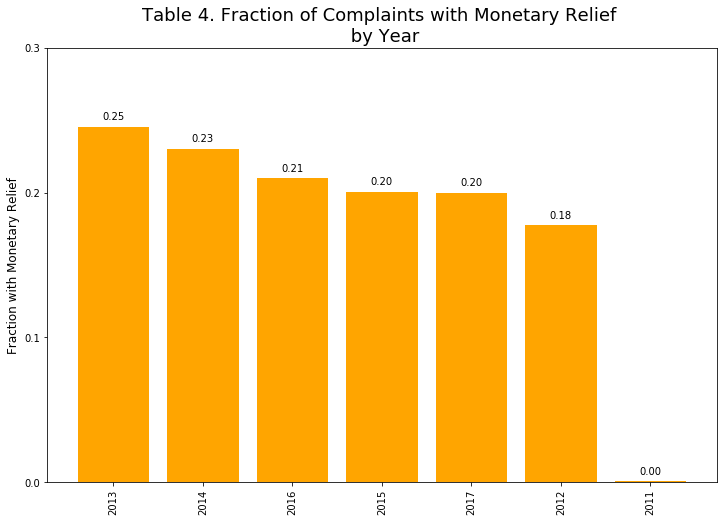

In [43]:
# Plot fraction of outcomes with monetary relief by Year
Y_by_Year = f.fraction_of_outcomes_with_monetary_relief(df,'Year')

#bar chart
f.bar_chart_Y_by_categories_of_variable(Y_by_Year, 'Year',
            'Table 4. Fraction of Complaints with Monetary Relief \n by Year')

Years 2013 and 2014 had the highest percentage of monetary resolutions. Note that 2011 seems to be an atypical year because it has few observations and essentially no resolutions with monetary relief. So I drop yar 2011 observations (n=1,260) and set year 2012 as my baseline year in regressions. 

In [44]:
# Drop year 2011 observations
df = df[df.Year != '2011']

# Create yearly dummies and make 2012 the excluded category
df = f.create_dummies(df, 'Year', 'Year', 'Year_2012')

### Variable *Month*

In [45]:
# Create Month variable from Date received
df['Month'] = df['Date received'].str[:2]

# Tabulate Month (%)
df.Month.value_counts(dropna=False)/df.shape[0]


02    0.096518
01    0.095537
03    0.086491
08    0.084233
10    0.084044
07    0.082719
09    0.082306
06    0.080426
04    0.078889
05    0.078853
12    0.075873
11    0.074112
Name: Month, dtype: float64

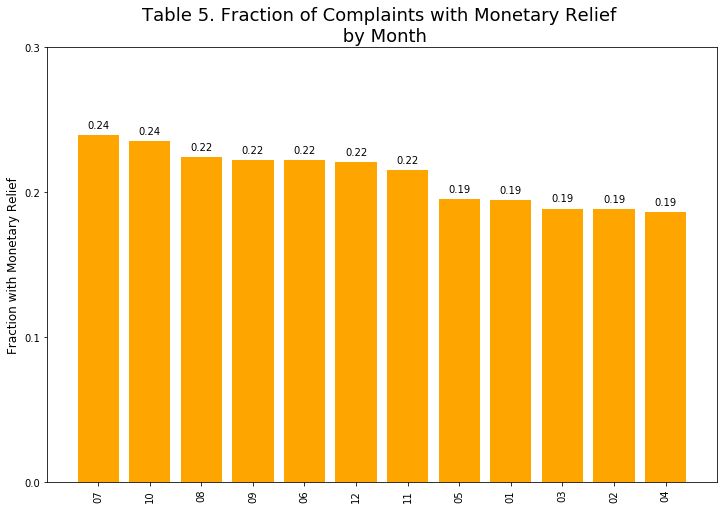

In [46]:
# Plot fraction of outcomes with monetary relief by Month
Y_by_Month = f.fraction_of_outcomes_with_monetary_relief(df,'Month')

#bar chart
f.bar_chart_Y_by_categories_of_variable(Y_by_Month, 'Month',
            'Table 5. Fraction of Complaints with Monetary Relief \n by Month')

Seasonality appears important as we observe some degree of variation in monetary resolution rates by month - July 24% vs April 19%.

In [47]:
# Create monthly dummy variables. Let April be the baseline (excluded) category.
df = f.create_dummies(df, 'Month', 'Month', 'Month_04')


##  Add American Community Survey (Census) Data

In [48]:
# Number of unique zip codes in the CFPB dataset
df['ZIP code'].nunique()

15402

Since there are over 15,000 zip codes, instead of creating that many zip code dummy variables, I add zip code-level socio-economic information from the American Community Survey (ACS) to control for this type of differences across zip codes.

In [53]:
# Load & process ACS data
socio_econ_data = pd.read_pickle(open(directory+'ACS_census_data.pickle', 'rb'))
socio_econ_data=f.process_zipcodes(socio_econ_data)

Length of the zip code in the dataset
5    33120
Name: ZIP code, dtype: int64

Number of non-alphanumeric characters: 
0

Alpha characters in the zip code:
Series([], Name: 0, dtype: int64)

Number of null values:  0


In [55]:
# Process CFPB data (zip codes)
df=f.process_zipcodes(df)

Length of the zip code in the dataset
5.0    83860
4.0       14
Name: ZIP code, dtype: int64

Number of non-alphanumeric characters: 
19

Alpha characters in the zip code:
X    17680
Name: 0, dtype: int64

Number of null values:  701


Note that the ACS (Census) data contains a pretty clean zip code variable that consists of 5 digits. 

Zip codes in the CFPB data, however, have missing values and occasionally contain some non-alphanumeric characters (-) or letter 'X'. This means that I will not be able to add ACS data to some zip codes in the CFPB data. 

My solution is to fill in missing values with means and create one dummy variable that would indicate which CFPB zip codes that could not be matched with ACS data. Note that the alternative solution of dropping missing values would result in a loss of at least 21% of complaints (=17,680/84,575). 

In [56]:
# All variables available in the ACS (Census) data
socio_econ_data.columns


Index(['ZIP code', 'unemployment_rate', 'Commutes_to_work_drives_alone',
       'Commutes_to_work_carpool', 'Commutes_to_work_public_transport',
       'Mean_travel_time', 'Median_household_income', 'percent_with_earnings',
       'percent_with_social_security', 'percent_with_retirement_income',
       'percent_with_supplementary_security_income',
       'percent_with_cash_public_assistance', 'percent_with_food_stamps_snap',
       'median_earnings_for_worker', 'median_earnings_for_male_worker',
       'median_earnings_for_female_worker',
       'percent_civil_pop_with_health_ins',
       'percent_civil_pop_with_private_health_ins',
       'percent_civil_pop_with_public_health_ins',
       'percent_civil_pop_without_health_ins',
       'percent_below_poverty_families', 'percent_below_poverty_people',
       'percent_below_poverty_under18yo', 'percent_below_poverty_ages18_plus',
       'percent_below_poverty_ages18_64', 'total_pop', 'age_0_19', 'age_20_29',
       'age_30_39', 'age_40_6

Some of the ACS variables listed above are either highly correlated (% of *families* below poverty line and % of *people* below poverty line) or collinear (% of people in various age categories). So below I select only some ACS variables to characterize socio-economic differences across zip codes.

In [57]:
# Select a subset of ACS variables
census_vars = ['ZIP code', 'unemployment_rate', 'Commutes_to_work_drives_alone', 
               'Mean_travel_time', 'Median_household_income', 'percent_with_earnings',
               'percent_civil_pop_without_health_ins', 'percent_below_poverty_families', 
               'median_age', 'age_0_19', 'age_65_plus']
socio_econ_data = socio_econ_data[census_vars]


In [58]:
# Add ACS data to the CFPB data
df = df.merge(socio_econ_data, on = 'ZIP code', how = 'left', indicator = True)
df._merge.value_counts()/df.shape[0] # 25% of observations have no ACS data


both          0.755507
left_only     0.244493
right_only    0.000000
Name: _merge, dtype: float64

In [59]:
# Replace missing ACS data with means
for i in census_vars[1:]:
        df[i] = df[i].fillna(df[i].mean())
        
# Create an indicator variable to mark Zip codes in the CFPB data that could not be matched with ACS data 
# (missing values)
df['ACS_missing'] = np.where(df._merge == 'left_only', 1, 0)


In [60]:
# Examine averages of ACS (Census) variables by outcome (Y)
pd.options.display.float_format = "{:,.1f}".format
df.groupby(['Y']).agg({'unemployment_rate': 'mean',
                      'Commutes_to_work_drives_alone':'mean',
                      'Mean_travel_time':'mean',
                      'Median_household_income':'mean',
                      'percent_with_earnings':'mean',
                      'percent_civil_pop_without_health_ins':'mean',
                      'percent_below_poverty_families':'mean',
                      'median_age':'mean',
                      'age_0_19':'mean',
                      'age_65_plus':'mean'
                      }).T
    

Y,0,1
unemployment_rate,8.0,7.8
Commutes_to_work_drives_alone,73.5,73.5
Mean_travel_time,27.1,27.1
Median_household_income,"66,430.1","67,100.9"
percent_with_earnings,79.2,79.3
percent_civil_pop_without_health_ins,11.5,11.3
percent_below_poverty_families,10.0,9.7
median_age,38.9,39.1
age_0_19,24.6,24.5
age_65_plus,14.5,14.6


The averages of ACS variables across the two categories of our outcome variable appear to be very similar. No significant differences really jump out at this point.

In [61]:
# Generate summary stats for all ACS (Census) variables
df[census_vars].describe().T


,count,mean,std,min,25%,50%,75%,max
unemployment_rate,"84,575.0",7.9,3.3,0.0,6.0,7.9,8.6,100.0
Commutes_to_work_drives_alone,"84,575.0",73.5,15.2,0.0,73.5,75.4,81.9,100.0
Mean_travel_time,"84,575.0",27.1,5.5,6.3,23.7,27.1,29.4,113.5
Median_household_income,"84,575.0","66,571.2","23,730.8","3,479.0","51,079.0","66,571.2","73,856.0","236,500.0"
percent_with_earnings,"84,575.0",79.2,7.4,0.0,77.3,79.2,83.2,100.0
percent_civil_pop_without_health_ins,"84,575.0",11.4,5.7,0.0,7.7,11.4,13.1,100.0
percent_below_poverty_families,"84,575.0",9.9,6.8,0.0,5.3,9.9,11.1,100.0
median_age,"84,575.0",38.9,5.5,15.5,36.0,38.9,41.1,91.8
age_0_19,"84,575.0",24.6,5.0,0.0,23.0,24.6,26.9,91.9
age_65_plus,"84,575.0",14.6,5.7,0.0,11.6,14.6,15.8,100.1


## Drivers of Monetary Relief in Credit Card Complaints

So far, what have we learned about determinants of whether a credit card complaint will be met with monetary relief?

- **Variable "Issue"** definitely seems to be the most important driver. When we tabulated the % of positive outcomes by Issue categories, fee- and billing-related complaints had a very high percentage of positive outcomes compared with complaints related to credit determination, etc. 


- **Companies** also seem to vary a great deal in the way they settle complaints, and preliminary analysis suggests that this is not necessarily entirely related to differences in the mix of credit card complaints handled by different companies. 


- **Year and month** the complaint was submitted to the CFPB also seem to add to the ability to predict positive outcomes. % of complaints with monetary relief ranges from 18% to 25% across years and from 19% to 24% across months (seasonality seems to matters).  


The rest of the variables seem to matter less for predictions because:

- The variable itself is dominated by one category (label) that drives the result, or
       (Tags, Timely response)
    

- There is not much differences in Y across categories, or
      (State, Presense of a complaint narrative, Tags, whether the consumer provided consent to share
      information, the way the complaint was submitted to the CFPB)


- Both 
      (Tags)
      
      
**Next,** I fit a decision tree (DT) classifier to the whole CFPB dataset to check which variables are important (based on the entropy criterion). I display a bar chart showing feature importance, as measured by information gain or decrease in entropy associated with the given variable. The DT results are consistent with the analysis listed above.

Note that I limit the depth of the tree to 10. This is completely arbitrary for now. I do this in order to avoid fitting the tree perfectly to data. This allows me to capture high-level patterns in data and minimize the influence of noise from overfitting.

## Decision tree-based feature importance

Before fitting the decision tree, I first need to encode labels of categorical variables, so that instead of labels such as 'Citibank', 'Discover', and 'JP Morgan', we would have numeric labels such as 0, 1, and 2 instead.

In [62]:
# Define a new dataset and label encoder function
df_encoded = df.astype('str')
le = preprocessing.LabelEncoder()

# Define variables to encode (note that these are original, un-recoded variables)
X= ['Issue', 'Is_narrative', 'Tags', 'Consumer consent provided?', 'Submitted via',
    'Timely response?', 'Company', 'State', 'Year', 'Month']

# Apply le.fit_transform to X
df_encoded[X] = df_encoded[X].apply(le.fit_transform)


In [63]:
# Fit a decision tree classifier of arbitrary depth 10 on the whole CFPB dataset 
# using criterion 'entropy'
clf = DecisionTreeClassifier(criterion='entropy', max_depth = 10)
clf = clf.fit(df_encoded[X],df_encoded.Y)


Feature Importance for DT trained on the whole CFPB dataset. Depth=10.


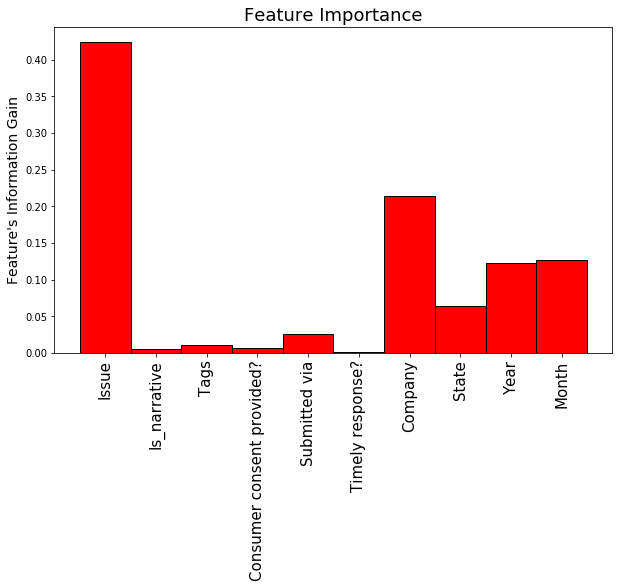

Features by Importance (Information gain or decrease in entropy)


[('Issue', '0.423'),
 ('Company', '0.213'),
 ('Month', '0.127'),
 ('Year', '0.123'),
 ('State', '0.064'),
 ('Submitted via', '0.026'),
 ('Tags', '0.010'),
 ('Consumer consent provided?', '0.007'),
 ('Is_narrative', '0.005'),
 ('Timely response?', '0.001')]

In [66]:
print("Feature Importance for DT trained on the whole CFPB dataset. Depth=10.")
f.feature_importance(clf, df_encoded[X+['Y']])


The decision tree results show that Issue is indeed a very important predictor of monetary relief, followed by Company, Month, Year, and State. 

Note that variable Issue continues to be the most important predictor in trees with length between 1 and 14. Things start to shift a bit, most likely due to extra noise, when we allow the decision tree grow longer (i.e., overfitting becomes a bigger concern).




**Next,** I drop redundant variables and save the file to be used in the next IPython Notebook, where I fit a logistic regression model.

- As was mentioned above, I decided to keep 'Date received' and drop 'Date sent to company.'


- Whether the consumer disputed the company's resolution is reported in 'Consumer disputed?' variable (Yes/No). Since it captures information that occured following the complaint resolution (post-outcome), it is a so called leakage variable and I drop it. Same for 'Company public response.'


- Drop redundant or re-coded variables such as:

    - 'Sub-product' & 'Sub-issue' (all nulls)
    - 'Complaint ID', 'ZIP code', 'Timely response?' (not used)
    - 'Product' (one value since we consider credit cards only)
    - 'Issue', 'Company', 'Date received', 'Consumer complaint narrative', 'Tags', 'Consumer   consent provided?', 'Submitted via', 'Timely response?'  (re-coded) 
    

- Finally, I also notice that dummy variables 'Is_narrative' and 'Consent provided' are identical, so I keep 'Is_narrative' and drop 'Consent provided.'

In [67]:
# 'Is_narrative' and 'Consent provided'  are perfectly collinear (have to drop one)
df[['Is_narrative', 'Consent provided']].corr()

,Is_narrative,Consent provided
Is_narrative,1.0,1.0
Consent provided,1.0,1.0


In [68]:
# Drop redundant or recoded variables
df = df.drop(columns = ['Sub-product', 'Sub-issue', 'Company', 'Issue', 'Issue_recoded',
                        'Complaint ID', 'Product', 'Date sent to company',
                        'Consumer complaint narrative', 'State', 'State_recoded', 'Tags',
                        'Consumer consent provided?', 'Consent provided', 'Submitted via',
                        'Date received', 'Year', 'Month', '_merge',
                        'Company_recoded', 'Timely response?', 
                        'ZIP code', 'Company public response',
                        'Consumer disputed?'], axis =1)


In [69]:
# List columns (variables)
df.columns

Index(['Y', 'Issue_APR or interest rate', 'Issue_Advertising and marketing',
       'Issue_Billing disputes', 'Issue_Billing statement',
       'Issue_Closing/Cancelling account',
       'Issue_Credit card protection / Debt protection',
       'Issue_Credit determination', 'Issue_Credit line increase/decrease',
       'Issue_Customer service / Customer relations',
       'Issue_Delinquent account',
       'Issue_Identity theft / Fraud / Embezzlement',
       'Issue_Issue-Other groupped', 'Issue_Late fee', 'Issue_Other fee',
       'Issue_Payoff process', 'Issue_Rewards', 'Issue_Transaction issue',
       'Issue_Unsolicited issuance of credit card', 'Is_narrative',
       'Company_Amex', 'Company_Bank of America', 'Company_Barclays PLC',
       'Company_Capital One', 'Company_Citibank', 'Company_Discover',
       'Company_JPMorgan Chase & Co.', 'Company_Synchrony Financial',
       'Company_U.S. Bancorp', 'Company_Wells Fargo & Company', 'State_AZ',
       'State_CA', 'State_FL', 'State

In [70]:
# Size of file
df.shape

(84575, 76)

In [71]:
# Save the final dataset and continue working in the next Ipython Notebook, where I identify
# the best logitistic model
with open(directory+'df.pickle', 'wb') as handle:
    pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# to open, use this command:
# df = pd.read_pickle(directory+"df.pickle")

Continue to IPython Notebook #2